<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 6th exercise: <font color="#C70039">Work with Autoencoders for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Name: Rubaiya Kabir Pranti
* Matriculation Number: 11146364
* Date: 16.01.2024

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float: center;" width="700">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
Autoencoder is an unsupervised artificial neural network (ANN) that learns how to efficiently compress and encode data and then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

An Autoencoder reduces data dimensions by learning how to ignore the noise in the data and thus outliers.
In the section above, you can seen an example of the input/output image from the MNIST dataset to an Autoencoder.

#### Autoencoder Components:
An Autoencoder consists of four main parts:

1. Encoder: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2. Bottleneck: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data. The bottlneck is also called latent vector. The concept of the latent space and latent vectors becomes important later on as we move forward to understand Generative Models. 

3. Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4. Reconstruction Loss: This is the method that measures how well the decoder is performing and how close the output is to the original input.

As always in ANNs, the training itself involves back propagation in order to minimize the network’s reconstruction loss.

Due to this features of an Autoencoder the use cases are manyfold. One of the obviously is anomaly detection. 

#### Autoencoder Architecture:

The network architecture for Autoencoders can vary between simple Feed Forward networks, Recurrent Neural Networks (LSTM) or Convolutional Neural Networks (CNN) depending on the use case. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * the example below shows how to use an autoencoder for anomaly detection

4. <font color=green>Develop an Autoencoder for Domain Adaptation (Me -> Walter White ). You can of course also take own data, e.g. a photo of yours and someone else.</font>
5. Set at least the following hyperparameters for training (epochs=100000, shuffle=True).
6. Implement a CNN for working out important features for the adaptation. If you feel lost in the exercise, please visit the sample solution.
7. There is also an implementation of data augmentation that helps you building up your data set from one single "original" image. 
---------------------------------

### Auto-Encoding
If you have correlated input data, the auto-encoder method will work very well because the encoding operation relies on the correlated features to compress the data.
Let’s consider that an auto-encoder is trained on the MNIST dataset. 
As you know already, using a simple FeedForward neural network, this can be done by building a simple 6 layers network as below:

In [1]:
# !pip install numpy pandas jupyter ipykernel

In [2]:
# !python -m ipykernel install --user --name=myenv

In [3]:
# !jupyter notebook

In [4]:
import numpy
print(numpy.__version__)

1.26.1


In [5]:
# !pip install --user --upgrade numpy

In [6]:
import tensorflow as tf
print(tf.__version__)

C:\Users\rubai\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


In [7]:
import os
import keras
import numpy as np
from   keras.datasets import mnist
from   keras.models import Sequential, Model
from   keras.layers import Dense, Input
from   keras import optimizers
from   keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# load the inbuild mnist data set (8-bit grayscale digits)
# https://en.wikipedia.org/wiki/MNIST_database

# the MNIST dataset, which contains 70,000 images of handwritten digits (60,000 for training and 10,000 for testing) is loaded
# each image is 28x28 pixels and is represented in grayscale (8-bit pixels, with values ranging from 0 to 255
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalizing the training and the validation data set
# the training (train_x) and testing (val_x) data are normalized by reshaping the images 
# from 28x28 pixels to 784-element vectors (since 28 * 28 = 784) 
# and scaling the pixel intensities to the range [0, 1] by dividing by 255 (since the pixel values range from 0 to 255)

train_x = x_train.reshape(60000, 784) / 255 #normalized
val_x = x_test.reshape(10000, 784) / 255

# building the auto-encoding layers
# a Sequential model is created, which is a linear stack of layers
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,))) # expects input with 784 features (the reshaped images)
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,   activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
# the final dense layer has 784 units (to reconstruct the original 784-pixel input) 
# and uses a sigmoid activation function to ensure the output values are in the range [0, 1], similar to the normalized input
autoencoder.add(Dense(784,  activation='sigmoid'))
# the autoencoder model is compiled with the mean squared error loss function and the Adam optimizer
# this sets up the network for training, where it will learn to compress the input to the bottleneck layer and 
# then reconstruct it as closely as possible to the original input
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

In [37]:
'''
NOTE:
-----
The Exponential Linear Unit (ELU) is an activation function for neural networks. 
In contrast to ReLUs (which you know), ELUs have negative values which allows them to push mean unit 
activations closer to zero like batch normalization but with lower computational complexity.
'''    

# train the model and finally assign the encoding to the decoder
'''
NOTE:
-----
make sure you understand, that you are training on train_x and not on train_y but train_x again for the reconstruction
the same for the validation (val_x, val_x)
'''
# training
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=100,shuffle=True, verbose=1, validation_data=(val_x, val_x))

Epoch 1/100
59/59 [==============================] - 4s 72ms/step - loss: 0.0181 - val_loss: 0.0177
Epoch 2/100
59/59 [==============================] - 4s 68ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 3/100
59/59 [==============================] - 4s 65ms/step - loss: 0.0173 - val_loss: 0.0169
Epoch 4/100
59/59 [==============================] - 4s 62ms/step - loss: 0.0170 - val_loss: 0.0167
Epoch 5/100
59/59 [==============================] - 4s 66ms/step - loss: 0.0166 - val_loss: 0.0163
Epoch 6/100
59/59 [==============================] - 3s 59ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 7/100
59/59 [==============================] - 3s 59ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 8/100
59/59 [==============================] - 3s 59ms/step - loss: 0.0159 - val_loss: 0.0157
Epoch 9/100
59/59 [==============================] - 4s 64ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 10/100
59/59 [==============================] - 4s 72ms/step - loss: 0.0154 - val_loss: 0.0152

In [38]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 bottleneck (Dense)          (None, 10)                1290      
                                                                 
 dense_2 (Dense)             (None, 128)               1408      
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 938522 (3.58 MB)
Trainable params: 938522 

# encoder

In [39]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
#creating a new model as encoder
#theline says that it creates a new model using Model (), that takes the same input as the original autoencoder 
#but outputs the result from the 'bottleneck' layer and it creates a model that includes only the encoding 
#part of the autoencoder, which can be used to transform the input data into its encoded (compressed) representation

In [40]:
encoded_data = encoder.predict(train_x)  # bottleneck representation=compressed data
#encoding the input data only
#This line uses the encoder model to predict the train_x data. It feeds the training data into the encoder and outputs the encoded (compressed) data. 
#The result- encoded_data is the data in its compressed form at the bottlenec

1875/1875 [==============================] - 9s 5ms/step


In [41]:
decoded_output = autoencoder.predict(train_x)        # reconstruction
#here, we are predicting or reconstructing the given input data from compressed data on the "train" data
# ideally, it should be val data or test data
# but for understanding, used train data
# where we can see reconstruction loss is very less as already model is trained on same dataset

1875/1875 [==============================] - 16s 8ms/step


# reconstruction loss

In [42]:
# train_x= original input data and decoded_output is our reconstructed data from the autoencoder
reconstruction_loss = np.mean(np.power(train_x - decoded_output, 2), axis=-1)

In [43]:
average_reconstruction_loss = np.mean(reconstruction_loss)
print("Average reconstruction loss:", average_reconstruction_loss)

Average reconstruction loss: 0.010099532625435555


## <font color="FFC300">Comments</font>:

As it is seen in the output, the last avg. reconstruction loss/error for the validation set is around 0.0100, which is great. 
Now, if we pass any normal image from the MNIST dataset, the reconstruction loss will be very low (< 0.02) BUT if we tried to pass any other different image (outlier / anomaly), we will get a high reconstruction loss value because the network failed to reconstruct the image/input that is considered an anomaly.

Notice in the code above, we can use only the encoder part to compress some data or images and we can also only use the decoder part to decompress the data by loading the decoder layers.

# individual decoder for understanding/returning the decoder

In [44]:
encoding_dim = 10
# the bottleneck layer (the middle layer of the autoencoder that contains the compressed representation of the input data)
# produces an output vector of size 10.

# returns the decoder
encoded_input = Input(shape=(encoding_dim,)) #this line creates an input layer for the decoder model
decoder = autoencoder.layers[-3](encoded_input) #it takes the third-to-last layer of the autoencoder and applies it to the 
#encoded_input. this is likely the first layer of the decoder part of the autoencoder
decoder = autoencoder.layers[-2](decoder) #this takes the second-to-last layer of the autoencoder 
#and applies it to the output of the previous layer (which is now called decoder)
decoder = autoencoder.layers[-1](decoder)#this takes the last layer of the autoencoder, 
#which should be the output layer that reconstructs the input data, and applies it to the output of the previous layer
decoder = Model(encoded_input, decoder) #This line is creating the decoder model itself
#the model takes encoded_input as its input and provides decoder as its output

In [45]:
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1408      
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 469648 (1.79 MB)
Trainable params: 469648 (1.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Auto-Encoders for Anomaly Detection
Now, let’s do some anomaly detection. The code below uses two different images to predict the anomaly score (reconstruction error) using the autoencoder network we trained above. 

The first image is from the MNIST and the result is error=2.20278686. This means that the image is not an anomaly. The second image (bird.png) obviously does not belong to the training dataset and the result is: error=3113.9646. This high error means that the image is an anomaly. Even the third image. The same concept applies to any type of dataset.

In [46]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

## <font color="FFC300">Comments</font>:

In [48]:
# If you are using a newer version of keras than '2.4.3', read this article below.
# It describes a versioning issue in the keras libs
'''https://stackoverflow.com/questions/72383347/how-to-fix-it-attributeerror-module-keras-preprocessing-image-has-no-attribu'''
from keras.preprocessing import image

# take an image from the validation data set or the training data set, respectively
input_img = val_x[60] 
input_img_flat = input_img.reshape(1,784)

target_data = autoencoder.predict(input_img_flat)

dist = np.linalg.norm(input_img_flat - target_data, axis=-1)
# euclidean distance (np.linalg.norm) will give a single scalar value representing the magnitude of the difference between the two images.
#mean squared error (the previous calculation) gives the average squared difference per pixel
# np.linalg.norm function computes the norm of the vector, which by default is the L2 norm
#it's the square root of the sum of the absolute squares of the differences between the corresponding elements of the two arrays. 
#when we use axis=-1, it computes the norm along the last axis, which means it calculates the norm for each row in a 2D array

print(dist)

1/1 [==============================] - 0s 68ms/step
[2.20278686]


In [50]:
# Now take bird as the test image bird.jpg. The error score will be very high (error=3113.9646)
img = load_img("./images/bird.jpg", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)
print(dist)

1/1 [==============================] - 0s 58ms/step
[3113.9646]


In [51]:
''' 
Now take a Mnist image which is taken from the google image search and although it is super similar to the training data
it does not belong to the same data distribution the auto-encoder was trained on. 
It produces an error almost as high as flower.jpg(approx error=1840.8634)
This makes autoencoders being a very robust technique for anomaly detection.
'''
img = load_img("./images/flower.jpg", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)

target_data = autoencoder.predict(input_img_flat)

dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 47ms/step
[1840.8634]


# Data augmentation

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [58]:
datagen = ImageDataGenerator(
                rotation_range=90,
                horizontal_flip=True,
                vertical_flip=True,
                width_shift_range=0.5,  # setting the value to 0.5 means max shift by 50% of the image width
                height_shift_range=0.5)  # setting the value to 0.5 means max shift by 50% of the image height

# original image(s)
img_folder = "./data_aug" #bird images
image_names = os.listdir(img_folder)

print('image_names:', image_names)

for filename in image_names:
    print(filename)
    img_path = os.path.join(img_folder, filename)  # Full path to the image
    img = load_img(img_path)  # Load the image from full path
    x = img_to_array(img)
    # Reshape the input image
    x = x.reshape((1,) + x.shape)
    i = 0

    # set n to the number of augmented images you want
    n = 50
    # make sure 'augmented' directory exists
    save_dir = os.path.join(img_folder, 'augmented')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    # generate n new augmented images and store them in an /augmented/ folder that exists 
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='aug_', save_format='jpg'):
        i += 1
        if i > n:
            break

image_names: ['bird.jpg']
bird.jpg


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

datagen = ImageDataGenerator(
                rotation_range=90,
                horizontal_flip=True,
                vertical_flip=True,
                width_shift_range=0.5,  # setting the value to 0.5 means max shift by 50% of the image width
                height_shift_range=0.5)  # setting the value to 0.5 means max shift by 50% of the image height

# original image(s)
img_folder = "./data_aug2" #flower images
image_names = os.listdir(img_folder)

print('image_names:', image_names)

for filename in image_names:
    print(filename)
    img_path = os.path.join(img_folder, filename)  # Full path to the image
    img = load_img(img_path)  # Load the image from full path
    x = img_to_array(img)
    # Reshape the input image
    x = x.reshape((1,) + x.shape)
    i = 0

    # set n to the number of augmented images you want
    n = 50
    # make sure 'augmented' directory exists
    save_dir = os.path.join(img_folder, 'augmented2')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    # generate n new augmented images and store them in an /augmented/ folder that exists 
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix='aug_', save_format='jpg'):
        i += 1
        if i > n:
            break


image_names: ['flower.jpg']
flower.jpg


# Domain Adaptaion

# How features from the bird domain could be mapped onto the flower domain

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import os
from   tqdm import tqdm
import time

SIZE=256

In [6]:
# import input img
input_img_data=[]
input_path = './data_aug/augmented/' #bird images>>>> input
files=os.listdir(input_path)

# read all images in the folder (different rotations and flips of the original)
for i in tqdm(files):
    img=cv2.imread(input_path+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    input_img_data.append(img_to_array(img))
    
    
# -----------------------------------------  
# import output_img
output_img_data=[]
output_path = './data_aug2/augmented2' #flower images>>>> output  
files=os.listdir(output_path)

# read all images in the folder (same rotations and flips as img)
for i in tqdm(files):
    img=cv2.imread(output_path+'/'+i,1)  #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    output_img_data.append(img_to_array(img))

input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
input_img_array = input_img_array.astype('float32') / 255. # normalize
output_img_array= np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
output_img_array = output_img_array.astype('float32') / 255. # normalize

# Original image for prediction of output_img 
# this one does not belong to the training set
test_img_data=[]

test_img=cv2.imread('./images/bird.jpg', 1)   #Change 0 to 1 for color images
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)#Changing BGR to RGB to show images in true colors
test_img=cv2.resize(test_img,(SIZE, SIZE))
test_img_data.append(img_to_array(test_img))

test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 3))
test_img_array = test_img_array.astype('float32') / 255. # normalize

# set the start time
# later needed for calculating the computation time
start=time.time()

100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 185.39it/s]


In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
     
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 8)       2312      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 8)        

In [8]:
#callbacks = [tf.keras.callbacks.TensorBoard(log_dir='einstein_logs')]

# fit the model of input_img to output_img 
epochs = 100
model.fit(input_img_array, output_img_array, epochs=epochs, shuffle=True)#, callbacks=callbacks)

# print out the computation time
finish=time.time()
print('total computation time = ', finish-start)

# save the model
model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".model")

Epoch 1/100
2/2 [==============================] - 8s 2s/step - loss: 0.0724 - accuracy: 0.2325
Epoch 2/100
2/2 [==============================] - 5s 2s/step - loss: 0.0596 - accuracy: 0.2353
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.0514 - accuracy: 0.2104
Epoch 4/100
2/2 [==============================] - 4s 2s/step - loss: 0.0486 - accuracy: 0.1558
Epoch 5/100
2/2 [==============================] - 4s 2s/step - loss: 0.0425 - accuracy: 0.1483
Epoch 6/100
2/2 [==============================] - 4s 2s/step - loss: 0.0409 - accuracy: 0.2854
Epoch 7/100
2/2 [==============================] - 4s 2s/step - loss: 0.0408 - accuracy: 0.6123
Epoch 8/100
2/2 [==============================] - 4s 2s/step - loss: 0.0404 - accuracy: 0.6183
Epoch 9/100
2/2 [==============================] - 4s 2s/step - loss: 0.0406 - accuracy: 0.6208
Epoch 10/100
2/2 [==============================] - 4s 2s/step - loss: 0.0403 - accuracy: 0.6211
Epoch 11/100
2/2 [=====================

2/2 [==============================] - 4s 2s/step - loss: 0.0379 - accuracy: 0.6211
Epoch 86/100
2/2 [==============================] - 4s 2s/step - loss: 0.0379 - accuracy: 0.6213
Epoch 87/100
2/2 [==============================] - 5s 2s/step - loss: 0.0379 - accuracy: 0.6211
Epoch 88/100
2/2 [==============================] - 4s 2s/step - loss: 0.0378 - accuracy: 0.6215
Epoch 89/100
2/2 [==============================] - 5s 2s/step - loss: 0.0379 - accuracy: 0.6217
Epoch 90/100
2/2 [==============================] - 5s 2s/step - loss: 0.0378 - accuracy: 0.6214
Epoch 91/100
2/2 [==============================] - 4s 2s/step - loss: 0.0378 - accuracy: 0.6208
Epoch 92/100
2/2 [==============================] - 4s 2s/step - loss: 0.0378 - accuracy: 0.6202
Epoch 93/100
2/2 [==============================] - 4s 2s/step - loss: 0.0378 - accuracy: 0.6209
Epoch 94/100
2/2 [==============================] - 4s 2s/step - loss: 0.0378 - accuracy: 0.6215
Epoch 95/100
2/2 [=========================

INFO:tensorflow:Assets written to: domain_adapt_autoenc_epochs.100.model\assets


##  For 100 epochs

output of test image
1/1 [==============================] - 0s 322ms/step


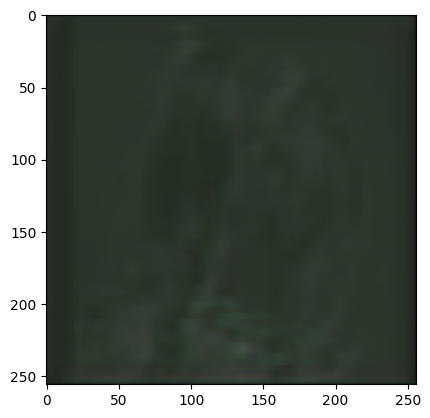

In [9]:
# predicted the original image as test image, 
# since it did not belong to the training data.
# if the domain was really adapted, then the result would look like output_img
print("output of test image")
pred = model.predict(test_img_array)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.show()

## <font color="FFC300">Comments</font>:

 - above domain adaptation is making a seq. model to be specializing in one domain/bird domain and then learns to apply that knowledge of bird domain to a different type of domain>flowers domain
 - in our example, there is no trace of flower which is for less training time
 - here, the model is trained in one domain called source domain>bird images to perform well on our new target domain>flower images
 - the features are learned from the bird domain which are adapted and effective in the flower domain

## For 100 epochs

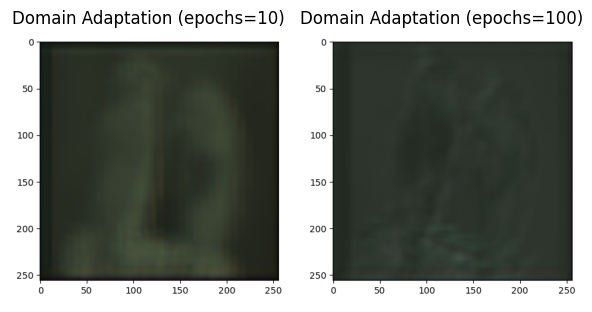

In [12]:
img_paths = [
    'C:/Users/rubai/AML/domain_adaptation.png',
    'C:/Users/rubai/AML/domain_adaptation2.png'
]

img_titles = ['Domain Adaptation (epochs=10)', 'Domain Adaptation (epochs=100)'] #with shuffle=True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 15))
axes_flat = axes.flatten()

for i, (path, title, ax) in enumerate(zip(img_paths, img_titles, axes_flat)):
    img = plt.imread(path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

 ## <font color="FFC300">Comments</font>:
 ### - for 100 epochs, domain adaptation did not necessarily lead towards better domain adaptation
 ### - and for 10 epochs, adaptation worked well with more details